In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display, clear_output

from scipy.stats import zscore
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_dir = os.getcwd()

In [4]:
# Set folder paths
# data_dir = os.path.join(script_dir, "data")
data_dir = os.path.abspath(os.path.join(script_dir, "..", "data"))

output_dir = os.path.join(script_dir,"..", "Output")
plots_dir = os.path.join(output_dir, "plots")
summary_dir = os.path.join(output_dir, "summary")
processed_data_dir = os.path.join(output_dir, "processed")

In [8]:
# Create output directories if they don't exist
for folder in [output_dir, plots_dir, summary_dir, processed_data_dir]:
    os.makedirs(folder, exist_ok=True)

In [11]:
# Load datasets
files = ["benin-malanville.csv"]
datasets = {}
for file in files:
    file_path = os.path.join(data_dir, file)
    print(f"Looking for file: {files}")
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    datasets[file.split(".")[0]] = pd.read_csv(file_path)

Looking for file: ['benin-malanville.csv']


In [14]:
# Function to save plots
def save_plot(fig, filename):
    fig.savefig(os.path.join(plots_dir, filename), bbox_inches="tight")
    plt.show()
    plt.close(fig)


In [15]:
# Function for summary statistics
def generate_summary_statistics(df, filename):
    summary = df.describe().T
    summary["missing"] = df.isnull().sum()
    summary.to_csv(os.path.join(summary_dir, filename))
    return summary

In [16]:
# Perform EDA on each dataset
for name, df in datasets.items():
    print(f"Processing dataset: {name}")

Processing dataset: benin-malanville


In [17]:
 # Summary statistics
summary = generate_summary_statistics(df, f"summary_{name}.csv")
print(summary)

                  count        mean         std    min    25%    50%    75%  \
GHI            525600.0  240.559452  331.131327  -12.9   -2.0    1.8  483.4   
DNI            525600.0  167.187516  261.710501   -7.8   -0.5   -0.1  314.2   
DHI            525600.0  115.358961  158.691074  -12.6   -2.1    1.6  216.3   
ModA           525600.0  236.589496  326.894859    0.0    0.0    4.5  463.7   
ModB           525600.0  228.883576  316.536515    0.0    0.0    4.3  447.9   
Tamb           525600.0   28.179683    5.924297   11.0   24.2   28.0   32.3   
RH             525600.0   54.487969   28.073069    2.1   28.8   55.1   80.1   
WS             525600.0    2.121113    1.603466    0.0    1.0    1.9    3.1   
WSgust         525600.0    2.809195    2.029120    0.0    1.3    2.6    4.1   
WSstdev        525600.0    0.473390    0.273395    0.0    0.4    0.5    0.6   
WD             525600.0  153.435172  102.332842    0.0   59.0  181.0  235.1   
WDstdev        525600.0    8.582407    6.385864    0

In [18]:
# Data quality check
print("Checking for missing values...")
missing_values = df.isnull().sum()
print(missing_values)

Checking for missing values...
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


In [19]:
print("Checking for outliers...")
numeric_cols = df.select_dtypes(include=[np.number]).columns
if not numeric_cols.empty:
    z_scores = np.abs(zscore(df[numeric_cols].dropna()))
    outliers = (z_scores > 3).sum(axis=0)
    print(outliers)

Checking for outliers...
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [21]:
# Time Series Analysis
time_cols = ["GHI", "DNI", "DHI", "Tamb"]
time_cols = [col for col in time_cols if col in df.columns]
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    df[time_cols].plot(ax=ax, title=f"Time Series Analysis: {name}")
    save_plot(fig, f"time_series_{name}.png")
    plt.show()

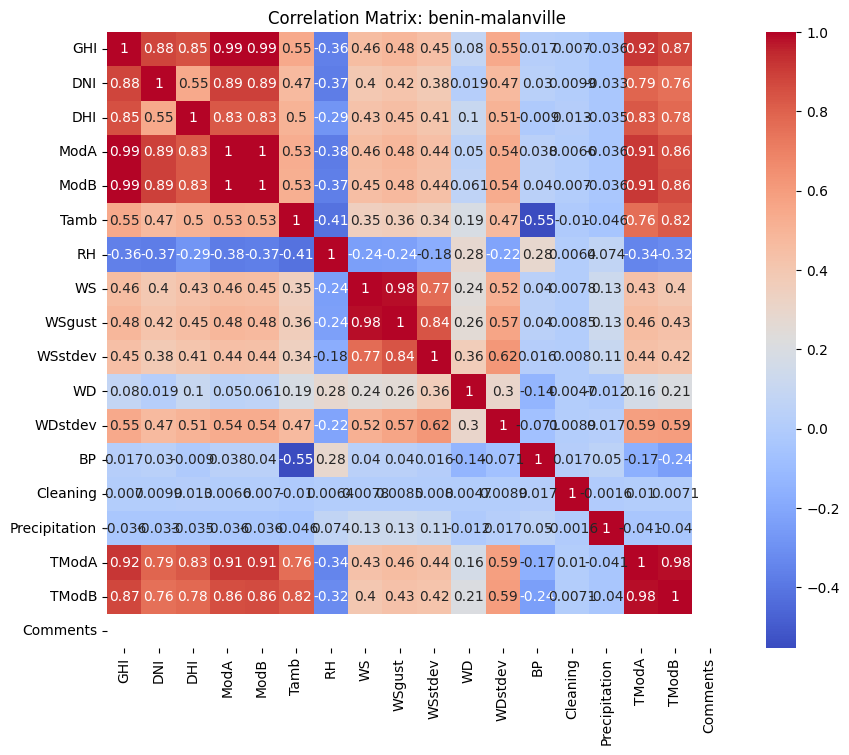

In [22]:
# Correlation Analysis
if not df[numeric_cols].empty:
    corr = df[numeric_cols].corr()
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)
    ax.set_title(f"Correlation Matrix: {name}")
    save_plot(fig, f"correlation_matrix_{name}.png")
    plt.show()

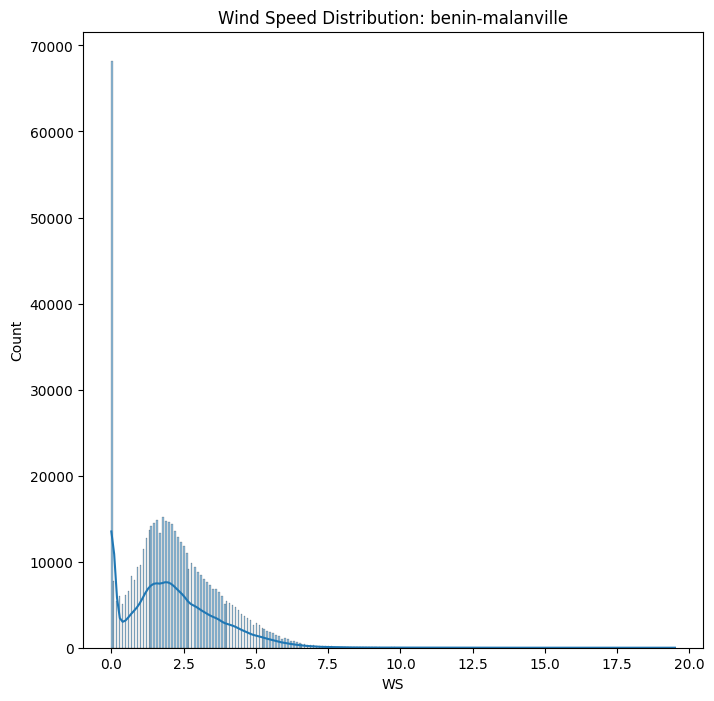

In [23]:
# Wind Analysis
if "WS" in df.columns and "WD" in df.columns:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(df["WS"], kde=True, ax=ax)
    ax.set_title(f"Wind Speed Distribution: {name}")
    save_plot(fig, f"wind_speed_distribution_{name}.png")
    plt.show()

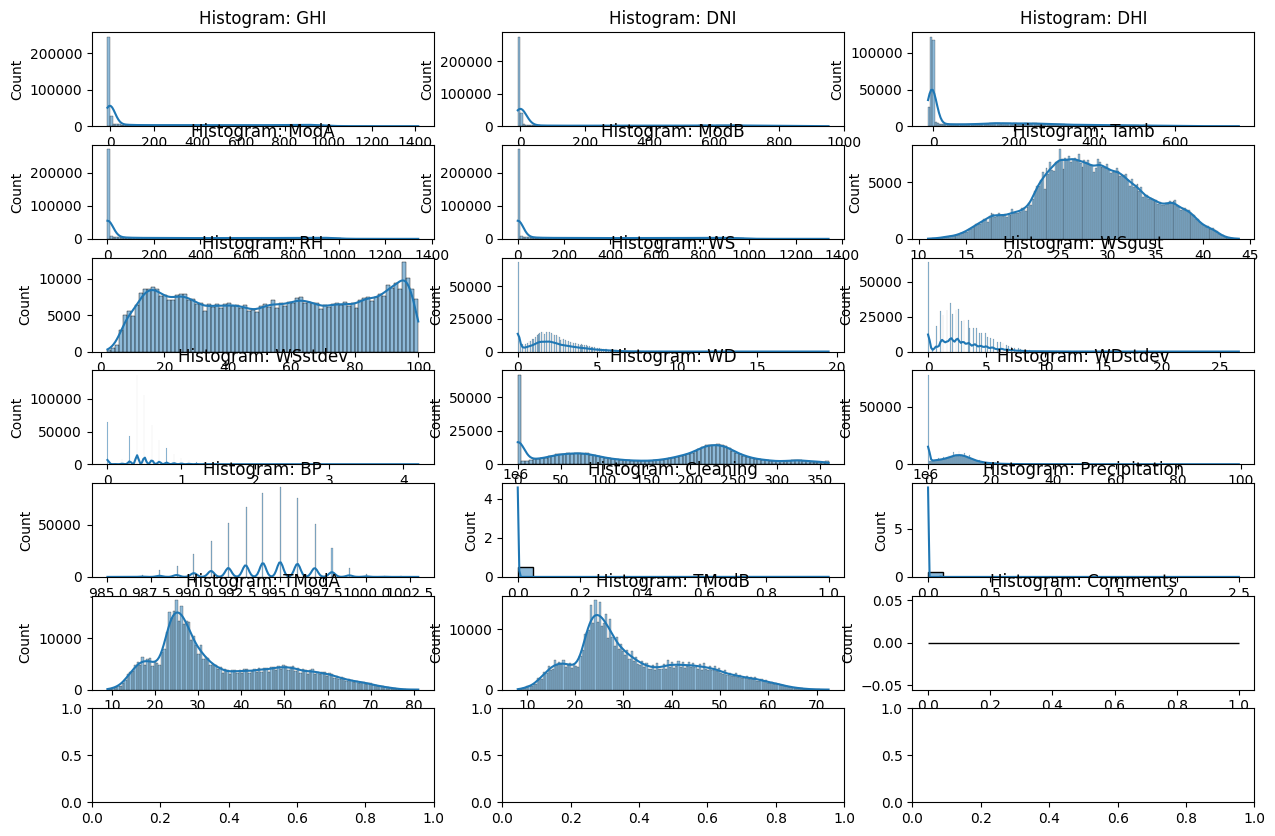

In [24]:
# Histograms
fig, axes = plt.subplots(len(numeric_cols) // 3 + 1, 3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Histogram: {col}")
save_plot(fig, f"histograms_{name}.png")
plt.show()

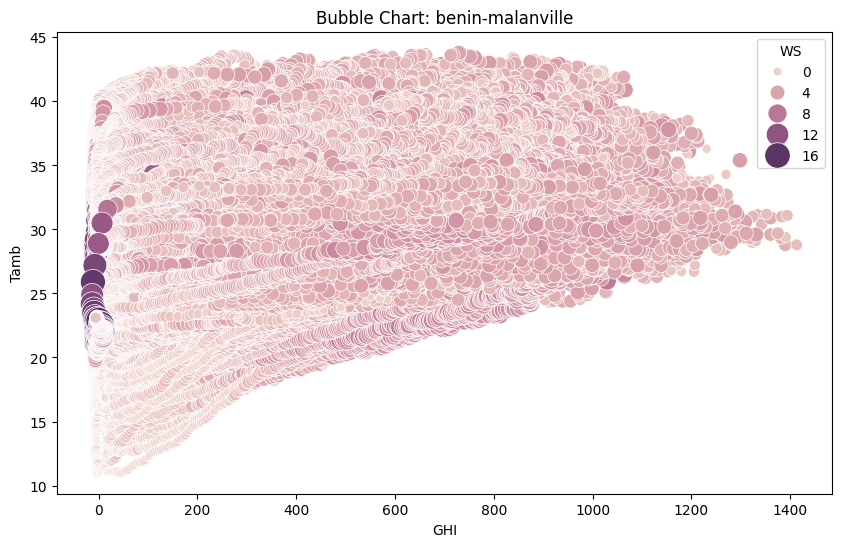

In [25]:
# Bubble Chart
bubble_vars = ["GHI", "Tamb", "WS", "RH"]
bubble_vars = [col for col in bubble_vars if col in df.columns]
if len(bubble_vars) >= 3:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        x=bubble_vars[0],
        y=bubble_vars[1],
        size=bubble_vars[2],
        hue=bubble_vars[2],
        sizes=(40, 400),
        data=df,
        ax=ax,
    )
    ax.set_title(f"Bubble Chart: {name}")
    save_plot(fig, f"bubble_chart_{name}.png")
    plt.show()

In [26]:
# Data Cleaning
if "Comments" in df.columns:
    df.drop(columns=["Comments"], inplace=True)

df.ffill(inplace=True)
df.bfill(inplace=True)

processed_file_path = os.path.join(processed_data_dir, f"cleaned_{name}.csv")
df.to_csv(processed_file_path, index=False)

print(f"Finished processing dataset: {name}\n")

Finished processing dataset: benin-malanville

